In [ ]:
# !pip install --upgrade grpcio
# !pip show grpcio
!pip install optuna
import optuna
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import make_scorer
from skimage.metrics import peak_signal_noise_ratio as psnr
from sklearn.base import BaseEstimator
from torch.nn import ReLU, LeakyReLU, Tanh

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
print(device)

cuda


In [ ]:
full_train_dataset = datasets.SVHN(root='./data', split='train', transform=transform, download=True)
train_size = int(0.8 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

test_dataset = datasets.SVHN(root='./data', split='test', transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

Using downloaded and verified file: ./data\train_32x32.mat
Using downloaded and verified file: ./data\test_32x32.mat


In [ ]:
class CNN_Autoencoder(nn.Module):
    def __init__(self, activation_fn=nn.ReLU(), optimizer_fn=optim.Adam, sparse=False):
        super(CNN_Autoencoder, self).__init__()
        self.sparse = sparse

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            activation_fn,
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            activation_fn,
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            activation_fn
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            activation_fn,
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            activation_fn,
            nn.ConvTranspose2d(32, 3, kernel_size=3, stride=1, padding=1),
            nn.Tanh()  # Use Tanh for output layer
        )

        # Optimizer setup as a parameter
        self.optimizer_fn = optimizer_fn

    def forward(self, x):
        encoded = self.encoder(x)
        if self.sparse:
            encoded = torch.abs(encoded)  # Enforce sparsity via L1
        decoded = self.decoder(encoded)
        return decoded

    def get_optimizer(self, lr=0.001):
        return self.optimizer_fn(self.parameters(), lr=lr)

In [ ]:
def train_autoencoder(model, optimizer, epochs=100, patience=10, loss_threshold=1e-4):
    criterion = nn.MSELoss()
    model.train()
    best_val_loss = float('inf')
    patience_counter = 0
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        total_loss = 0
        val_loss = 0

        # Training loop
        for images, _ in train_loader:
            images = images.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, images)
            loss.backward()

            # Apply weight clipping
            for param in model.parameters():
                param.data = torch.clamp(param.data, -0.5, 0.5)

            optimizer.step()
            total_loss += loss.item()

        # Validation loop
        model.eval()
        with torch.no_grad():
            for images, _ in val_loader:
                images = images.to(device)
                outputs = model(images)
                val_loss += criterion(outputs, images).item()
        val_loss /= len(val_loader)
        model.train()

        train_losses.append(total_loss / len(train_loader))
        val_losses.append(val_loss)

        print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")

        # Enhanced Early Stopping condition
        if val_loss < best_val_loss - loss_threshold:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

    return train_losses, val_losses

In [ ]:
model_base = CNN_Autoencoder().to(device)
model_sparse = CNN_Autoencoder(sparse=True).to(device)

optimizer_base = optim.Adam(model_base.parameters(), lr=0.001)
optimizer_sparse = optim.Adam(model_sparse.parameters(), lr=0.001)

In [ ]:
print("Training the base Autoencoder\n")
train_losses_base, val_losses_base = train_autoencoder(model_base, optimizer_base, epochs=100, patience=5)

print("\n========================================\nTraining the Autoencoder with L1-based sparsity constraint\n")
train_losses_sparse, val_losses_sparse = train_autoencoder(model_sparse, optimizer_sparse, epochs=100, patience=5)

Training the base Autoencoder

Epoch [1/100], Train Loss: 0.0047, Val Loss: 0.0008
Epoch [2/100], Train Loss: 0.0006, Val Loss: 0.0004
Epoch [3/100], Train Loss: 0.0004, Val Loss: 0.0003
Epoch [4/100], Train Loss: 0.0003, Val Loss: 0.0002
Epoch [5/100], Train Loss: 0.0003, Val Loss: 0.0003
Epoch [6/100], Train Loss: 0.0002, Val Loss: 0.0002
Epoch [7/100], Train Loss: 0.0002, Val Loss: 0.0002
Epoch [8/100], Train Loss: 0.0002, Val Loss: 0.0002
Epoch [9/100], Train Loss: 0.0002, Val Loss: 0.0001
Epoch [10/100], Train Loss: 0.0002, Val Loss: 0.0001
Epoch [11/100], Train Loss: 0.0002, Val Loss: 0.0001
Early stopping triggered.

Training the Autoencoder with L1-based sparsity constraint

Epoch [1/100], Train Loss: 0.0056, Val Loss: 0.0007
Epoch [2/100], Train Loss: 0.0006, Val Loss: 0.0004
Epoch [3/100], Train Loss: 0.0004, Val Loss: 0.0003
Epoch [4/100], Train Loss: 0.0004, Val Loss: 0.0005
Epoch [5/100], Train Loss: 0.0003, Val Loss: 0.0004
Epoch [6/100], Train Loss: 0.0002, Val Loss: 0.0

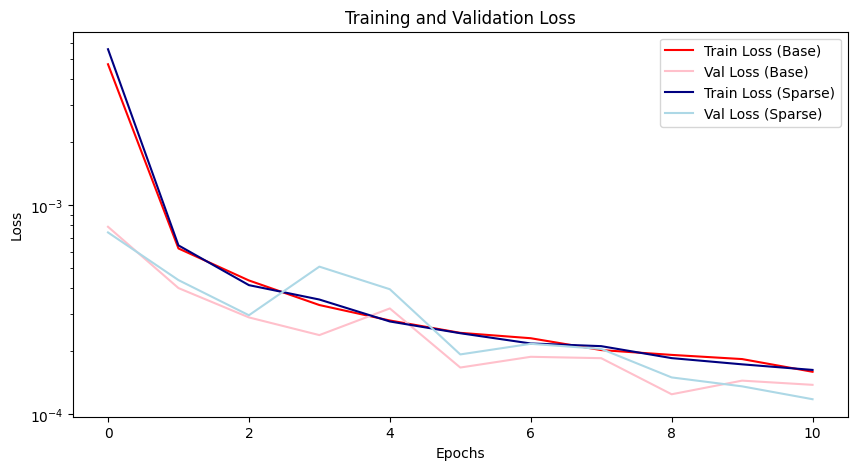

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(train_losses_base, label='Train Loss (Base)', c='r')
plt.plot(val_losses_base, label='Val Loss (Base)', c='pink')
plt.plot(train_losses_sparse, label='Train Loss (Sparse)', c='navy')
plt.plot(val_losses_sparse, label='Val Loss (Sparse)', c='lightblue')
plt.yscale('log')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
def evaluate_psnr(model, dataloader):
    total_psnr = 0
    with torch.no_grad():
        for images, _ in dataloader:
            images = images.to(device)
            outputs = model(images)
            images_np = images.cpu()
            outputs_np = outputs.cpu()
            batch_psnr = np.mean([psnr(images_np[i], outputs_np[i]) for i in range(len(images_np))])
            total_psnr += batch_psnr
    return total_psnr / len(dataloader)

In [ ]:
psnr_base = evaluate_psnr(model_base, test_loader)
psnr_sparse = evaluate_psnr(model_sparse, test_loader)

print(f"PSNR (Base Autoencoder): {psnr_base:.2f} dB")
print(f"PSNR (Sparse Autoencoder): {psnr_sparse:.2f} dB")

PSNR (Base Autoencoder): 40.34 dB
PSNR (Sparse Autoencoder): 41.26 dB


Autoencoder without sparsity constraint


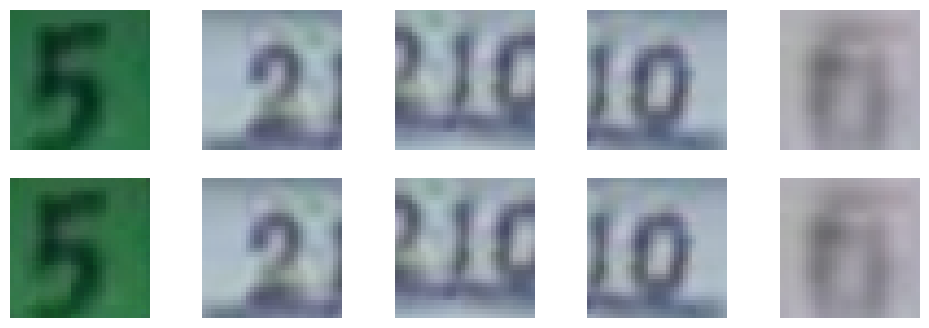

Autoencoder with sparsity constraint


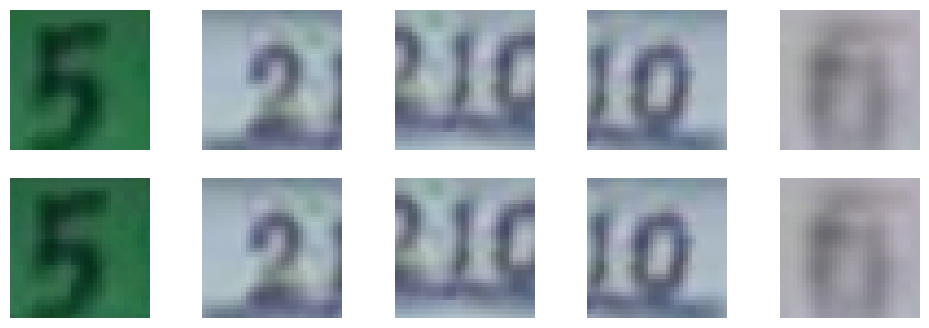

In [ ]:
def display_reconstructed_images(model, dataloader, num_images=5):
    model.eval()
    images, _ = next(iter(dataloader))
    images = images.to(device)
    with torch.no_grad():
        outputs = model(images)

    images = images.cpu().numpy().transpose(0, 2, 3, 1)
    outputs = outputs.cpu().numpy().transpose(0, 2, 3, 1)

    fig, axes = plt.subplots(2, num_images, figsize=(12, 4))
    for i in range(num_images):
        axes[0, i].imshow((images[i] * 0.5 + 0.5))
        axes[0, i].axis('off')
        axes[1, i].imshow((outputs[i] * 0.5 + 0.5))
        axes[1, i].axis('off')
    plt.show()

print("Autoencoder without sparsity constraint")
display_reconstructed_images(model_base, test_loader)
print("Autoencoder with sparsity constraint")
display_reconstructed_images(model_sparse, test_loader)

In [ ]:
def psnr(target, prediction, max_value=1.0):
    mse = torch.mean((target - prediction) ** 2)
    return 20 * torch.log10(max_value / torch.sqrt(mse))

def psnr_scorer(y_true, y_pred):
    y_true_tensor = torch.tensor(y_true).float()
    y_pred_tensor = torch.tensor(y_pred).float()
    return psnr(y_true_tensor, y_pred_tensor).item()

In [ ]:
class CNN_Autoencoder_SklearnWrapper(BaseEstimator):
    def __init__(self, activation_fn=ReLU(), optimizer_fn=optim.Adam, sparse=False, lr=0.001):
        self.activation_fn = activation_fn
        self.optimizer_fn = optimizer_fn
        self.sparse = sparse
        self.lr = lr
        self.model = CNN_Autoencoder(activation_fn=activation_fn, optimizer_fn=optimizer_fn, sparse=sparse)

    def fit(self, X, y=None):
        self.model.train()
        optimizer = self.model.get_optimizer(lr=self.lr)
        criterion = nn.MSELoss()

        for epoch in range(10):  # Number of epochs for grid search
            for i, (inputs, _) in enumerate(X):  # Ignore labels
                optimizer.zero_grad()
                outputs = self.model(inputs)

                # Debugging: Print shapes
                # print(f"Input shape: {inputs.shape}, Output shape: {outputs.shape}")

                loss = criterion(outputs, inputs.float())  # Targets should be inputs
                loss.backward()
                optimizer.step()

        return self


    def predict(self, X):
        self.model.eval()
        outputs_list = []
        with torch.no_grad():
            for inputs, _ in X:  # Ignore labels
                outputs = self.model(inputs)
                outputs_list.append(outputs.cpu().numpy())  # Convert to NumPy
        return np.concatenate(outputs_list, axis=0)  # Stack along batch dimension


# class CNN_Autoencoder_SklearnWrapper(BaseEstimator):
#     def __init__(self, activation_fn=None, optimizer_fn=optim.Adam, sparse=False, lr=0.001):
#         self.activation_fn = activation_fn
#         self.optimizer_fn = optimizer_fn
#         self.sparse = sparse
#         self.lr = lr
#         self._initialize_model()  # Initialize model inside constructor

#     def _initialize_model(self):
#         """ Initializes the PyTorch model and optimizer """
#         self.model = CNN_Autoencoder(activation_fn=self.activation_fn, sparse=self.sparse)
#         self.optimizer = self.optimizer_fn(self.model.parameters(), lr=self.lr)

#     def fit(self, X, y=None):
#         """ Trains the autoencoder with NumPy input """
#         X_tensor = torch.tensor(X, dtype=torch.float32)
#         train_loader = DataLoader(X_tensor, batch_size=64, shuffle=True)
#         X_reshaped = X.reshape(X.shape[0], 3, 32, 32)
#         self.model.train()
#         for epoch in range(5):  # Example: 5 epochs
#             for batch in train_loader:
#                 self.optimizer.zero_grad()
#                 outputs = self.model(batch)
#                 loss = F.mse_loss(outputs, batch)
#                 loss.backward()
#                 self.optimizer.step()
#         return self

#     def predict(self, X):
#         """ Reconstruct input using the trained autoencoder """
#         self.model.eval()
#         X_tensor = torch.tensor(X, dtype=torch.float32)
#         X_reshaped = X.reshape(X.shape[0], 3, 32, 32)
#         with torch.no_grad():
#             return self.model(X_tensor).numpy()  # Convert output back to NumPy

#     def score(self, X, y=None):
#         """ Compute PSNR Score """
#         X_reconstructed = self.predict(X)
#         return psnr(X, X_reconstructed)  # Use your PSNR function

In [ ]:
def objective(trial):
    # Hyperparameters to tune
    activation_fn = trial.suggest_categorical('activation_fn', [ReLU, LeakyReLU, Tanh])  # Pass classes, not instances
    activation_fn = activation_fn()
    lr = trial.suggest_float('lr', 0.0001, 0.01)
    optimizer_fn = trial.suggest_categorical('optimizer_fn', [optim.Adam, optim.SGD, optim.RMSprop])

    print(f"Trial {trial.number} - Learning Rate: {lr}, activation: {activation_fn}")

    full_train_dataset = datasets.SVHN(root='./data', split='train', transform=transform, download=True)

    train_data = full_train_dataset.data
    train_labels = full_train_dataset.labels

    # Check for GPU availability
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Initialize model (make sure this is a subclass of nn.Module)
    model = CNN_Autoencoder_SklearnWrapper(
        activation_fn=activation_fn,
        optimizer_fn=optimizer_fn,
        sparse=False,
        lr=lr
    )

    # Ensure the model's actual PyTorch model is moved to the correct device
    model.model = model.model.to(device)  # Move model to GPU

    # Split the dataset using KFold (reuse your previous code here)
    kf = KFold(n_splits=3, shuffle=True)
    fold_scores = []

    for train_idx, val_idx in kf.split(train_data):
        train_fold_data = torch.tensor(train_data[train_idx], dtype=torch.float32).permute(0, 1, 3, 2).to(device)
        train_fold_labels = torch.tensor(train_labels[train_idx], dtype=torch.long).to(device)
        val_fold_data = torch.tensor(train_data[val_idx], dtype=torch.float32).permute(0, 1, 3, 2).to(device)
        val_fold_labels = torch.tensor(train_labels[val_idx], dtype=torch.long).to(device)

        train_loader = DataLoader(
            list(zip(train_fold_data, train_fold_labels)),
            batch_size=64, shuffle=True
        )
        val_loader = DataLoader(
            list(zip(val_fold_data, val_fold_labels)),
            batch_size=64, shuffle=True
        )

        # Fit model (ensure the data is on the correct device)
        model.fit(train_loader, None)

        # Evaluate the model on the validation fold
        model.model.eval()
        val_psnr = 0.0
        with torch.no_grad():
            for inputs, _ in val_loader:  # Ignore the labels
                inputs = inputs.to(device)
                outputs = model.model(inputs)
                # print(f"Outputs shape: {outputs.shape}, Inputs shape: {inputs.shape}")  # Check if they match
                val_psnr += psnr(inputs, outputs)  # Compare the input and output images
        fold_scores.append(val_psnr / len(val_loader))

    mean_score = np.mean([score.cpu().numpy() for score in fold_scores])

    # Return the mean PSNR as the objective value
    return mean_score

In [ ]:
# Create study and optimize
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)  # You can set n_trials to any number you prefer

print(f"Best hyperparameters: {study.best_params}")

[I 2025-02-02 14:35:39,075] A new study created in memory with name: no-name-3906ce79-ff52-4dcb-b3b8-b2781a13036e


Trial 0 - Learning Rate: 0.005096351928864123, activation: Tanh()
Using downloaded and verified file: ./data\train_32x32.mat


[I 2025-02-02 14:38:42,616] Trial 0 finished with value: -41.91798782348633 and parameters: {'activation_fn': <class 'torch.nn.modules.activation.Tanh'>, 'lr': 0.005096351928864123, 'optimizer_fn': <class 'torch.optim.sgd.SGD'>}. Best is trial 0 with value: -41.91798782348633.


Trial 1 - Learning Rate: 0.008310381603633964, activation: Tanh()
Using downloaded and verified file: ./data\train_32x32.mat


[I 2025-02-02 14:41:45,536] Trial 1 finished with value: -41.91868591308594 and parameters: {'activation_fn': <class 'torch.nn.modules.activation.Tanh'>, 'lr': 0.008310381603633964, 'optimizer_fn': <class 'torch.optim.rmsprop.RMSprop'>}. Best is trial 0 with value: -41.91798782348633.


Trial 2 - Learning Rate: 0.005294449565525911, activation: ReLU()
Using downloaded and verified file: ./data\train_32x32.mat


[I 2025-02-02 14:44:49,273] Trial 2 finished with value: -41.91892623901367 and parameters: {'activation_fn': <class 'torch.nn.modules.activation.ReLU'>, 'lr': 0.005294449565525911, 'optimizer_fn': <class 'torch.optim.rmsprop.RMSprop'>}. Best is trial 0 with value: -41.91798782348633.


Trial 3 - Learning Rate: 0.005749473081422798, activation: LeakyReLU(negative_slope=0.01)
Using downloaded and verified file: ./data\train_32x32.mat


[I 2025-02-02 14:47:50,431] Trial 3 finished with value: -41.918399810791016 and parameters: {'activation_fn': <class 'torch.nn.modules.activation.LeakyReLU'>, 'lr': 0.005749473081422798, 'optimizer_fn': <class 'torch.optim.adam.Adam'>}. Best is trial 0 with value: -41.91798782348633.


Trial 4 - Learning Rate: 0.00670549299984881, activation: LeakyReLU(negative_slope=0.01)
Using downloaded and verified file: ./data\train_32x32.mat


[I 2025-02-02 14:50:56,184] Trial 4 finished with value: -41.91897201538086 and parameters: {'activation_fn': <class 'torch.nn.modules.activation.LeakyReLU'>, 'lr': 0.00670549299984881, 'optimizer_fn': <class 'torch.optim.adam.Adam'>}. Best is trial 0 with value: -41.91798782348633.


Trial 5 - Learning Rate: 0.0011641856974975503, activation: LeakyReLU(negative_slope=0.01)
Using downloaded and verified file: ./data\train_32x32.mat


[I 2025-02-02 14:53:58,339] Trial 5 finished with value: -41.918697357177734 and parameters: {'activation_fn': <class 'torch.nn.modules.activation.LeakyReLU'>, 'lr': 0.0011641856974975503, 'optimizer_fn': <class 'torch.optim.adam.Adam'>}. Best is trial 0 with value: -41.91798782348633.


Trial 6 - Learning Rate: 0.0018799041447780896, activation: Tanh()
Using downloaded and verified file: ./data\train_32x32.mat


[I 2025-02-02 14:57:00,856] Trial 6 finished with value: -41.91877365112305 and parameters: {'activation_fn': <class 'torch.nn.modules.activation.Tanh'>, 'lr': 0.0018799041447780896, 'optimizer_fn': <class 'torch.optim.adam.Adam'>}. Best is trial 0 with value: -41.91798782348633.


Trial 7 - Learning Rate: 0.008181228708877702, activation: LeakyReLU(negative_slope=0.01)
Using downloaded and verified file: ./data\train_32x32.mat


[I 2025-02-02 15:00:03,310] Trial 7 finished with value: -41.91835403442383 and parameters: {'activation_fn': <class 'torch.nn.modules.activation.LeakyReLU'>, 'lr': 0.008181228708877702, 'optimizer_fn': <class 'torch.optim.rmsprop.RMSprop'>}. Best is trial 0 with value: -41.91798782348633.


Trial 8 - Learning Rate: 0.006404403564802816, activation: LeakyReLU(negative_slope=0.01)
Using downloaded and verified file: ./data\train_32x32.mat


[I 2025-02-02 15:03:07,559] Trial 8 finished with value: -41.917789459228516 and parameters: {'activation_fn': <class 'torch.nn.modules.activation.LeakyReLU'>, 'lr': 0.006404403564802816, 'optimizer_fn': <class 'torch.optim.adam.Adam'>}. Best is trial 8 with value: -41.917789459228516.


Trial 9 - Learning Rate: 0.004088249587084291, activation: LeakyReLU(negative_slope=0.01)
Using downloaded and verified file: ./data\train_32x32.mat


[I 2025-02-02 15:06:06,974] Trial 9 finished with value: -41.91831970214844 and parameters: {'activation_fn': <class 'torch.nn.modules.activation.LeakyReLU'>, 'lr': 0.004088249587084291, 'optimizer_fn': <class 'torch.optim.sgd.SGD'>}. Best is trial 8 with value: -41.917789459228516.


Best hyperparameters: {'activation_fn': <class 'torch.nn.modules.activation.LeakyReLU'>, 'lr': 0.006404403564802816, 'optimizer_fn': <class 'torch.optim.adam.Adam'>}


In [ ]:
def objective_sparse(trial):
    # Hyperparameters to tune
    activation_fn = trial.suggest_categorical('activation_fn', [ReLU, LeakyReLU, Tanh])  # Pass classes, not instances
    activation_fn = activation_fn()
    lr = trial.suggest_float('lr', 0.0001, 0.01)
    optimizer_fn = trial.suggest_categorical('optimizer_fn', [optim.Adam, optim.SGD, optim.RMSprop])

    print(f"Trial {trial.number} - Learning Rate: {lr}, activation: {activation_fn}")

    full_train_dataset = datasets.SVHN(root='./data', split='train', transform=transform, download=True)

    train_data = full_train_dataset.data
    train_labels = full_train_dataset.labels

    # Check for GPU availability
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Initialize model (make sure this is a subclass of nn.Module)
    model = CNN_Autoencoder_SklearnWrapper(
        activation_fn=activation_fn,
        optimizer_fn=optimizer_fn,
        sparse=True,
        lr=lr
    )

    # Ensure the model's actual PyTorch model is moved to the correct device
    model.model = model.model.to(device)  # Move model to GPU

    # Split the dataset using KFold (reuse your previous code here)
    kf = KFold(n_splits=3, shuffle=True)
    fold_scores = []

    for train_idx, val_idx in kf.split(train_data):
        train_fold_data = torch.tensor(train_data[train_idx], dtype=torch.float32).permute(0, 1, 3, 2).to(device)
        train_fold_labels = torch.tensor(train_labels[train_idx], dtype=torch.long).to(device)
        val_fold_data = torch.tensor(train_data[val_idx], dtype=torch.float32).permute(0, 1, 3, 2).to(device)
        val_fold_labels = torch.tensor(train_labels[val_idx], dtype=torch.long).to(device)

        train_loader = DataLoader(
            list(zip(train_fold_data, train_fold_labels)),
            batch_size=64, shuffle=True
        )
        val_loader = DataLoader(
            list(zip(val_fold_data, val_fold_labels)),
            batch_size=64, shuffle=True
        )

        # Fit model (ensure the data is on the correct device)
        model.fit(train_loader, None)

        # Evaluate the model on the validation fold
        model.model.eval()
        val_psnr = 0.0
        with torch.no_grad():
            for inputs, _ in val_loader:  # Ignore the labels
                inputs = inputs.to(device)
                outputs = model.model(inputs)
                # print(f"Outputs shape: {outputs.shape}, Inputs shape: {inputs.shape}")  # Check if they match
                val_psnr += psnr(inputs, outputs)  # Compare the input and output images
        fold_scores.append(val_psnr / len(val_loader))

    mean_score = np.mean([score.cpu().numpy() for score in fold_scores])

    # Return the mean PSNR as the objective value
    return mean_score

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective_sparse, n_trials=10)

print(f"Best hyperparameters: {study.best_params}")

[I 2025-02-02 15:10:03,353] A new study created in memory with name: no-name-c744d9cc-320b-4736-babe-e9a0e7f7f3a6
C:\Users\91883\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.nn.modules.activation.ReLU'> which is of type type.
  warnings.warn(message)
C:\Users\91883\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.nn.modules.activation.LeakyReLU'> which is of type type.
  warnings.warn(message)
C:\Users\91883\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persi

Trial 0 - Learning Rate: 0.0013719402363322783, activation: ReLU()
Using downloaded and verified file: ./data\train_32x32.mat


[I 2025-02-02 15:13:04,155] Trial 0 finished with value: -41.9201774597168 and parameters: {'activation_fn': <class 'torch.nn.modules.activation.ReLU'>, 'lr': 0.0013719402363322783, 'optimizer_fn': <class 'torch.optim.sgd.SGD'>}. Best is trial 0 with value: -41.9201774597168.


Trial 1 - Learning Rate: 0.004520338920653176, activation: LeakyReLU(negative_slope=0.01)
Using downloaded and verified file: ./data\train_32x32.mat


[I 2025-02-02 15:16:05,696] Trial 1 finished with value: -41.9193000793457 and parameters: {'activation_fn': <class 'torch.nn.modules.activation.LeakyReLU'>, 'lr': 0.004520338920653176, 'optimizer_fn': <class 'torch.optim.sgd.SGD'>}. Best is trial 1 with value: -41.9193000793457.


Trial 2 - Learning Rate: 0.006545334323745731, activation: ReLU()
Using downloaded and verified file: ./data\train_32x32.mat


[I 2025-02-02 15:19:39,101] Trial 2 finished with value: -41.91835403442383 and parameters: {'activation_fn': <class 'torch.nn.modules.activation.ReLU'>, 'lr': 0.006545334323745731, 'optimizer_fn': <class 'torch.optim.adam.Adam'>}. Best is trial 2 with value: -41.91835403442383.


Trial 3 - Learning Rate: 0.007688252937635336, activation: ReLU()
Using downloaded and verified file: ./data\train_32x32.mat


[I 2025-02-02 15:22:51,687] Trial 3 finished with value: -41.91978454589844 and parameters: {'activation_fn': <class 'torch.nn.modules.activation.ReLU'>, 'lr': 0.007688252937635336, 'optimizer_fn': <class 'torch.optim.sgd.SGD'>}. Best is trial 2 with value: -41.91835403442383.


Trial 4 - Learning Rate: 0.000905323621649112, activation: LeakyReLU(negative_slope=0.01)
Using downloaded and verified file: ./data\train_32x32.mat


[I 2025-02-02 15:26:30,068] Trial 4 finished with value: -41.918766021728516 and parameters: {'activation_fn': <class 'torch.nn.modules.activation.LeakyReLU'>, 'lr': 0.000905323621649112, 'optimizer_fn': <class 'torch.optim.adam.Adam'>}. Best is trial 2 with value: -41.91835403442383.


Trial 5 - Learning Rate: 0.004014154240902336, activation: Tanh()
Using downloaded and verified file: ./data\train_32x32.mat


[I 2025-02-02 15:29:59,818] Trial 5 finished with value: -41.918888092041016 and parameters: {'activation_fn': <class 'torch.nn.modules.activation.Tanh'>, 'lr': 0.004014154240902336, 'optimizer_fn': <class 'torch.optim.rmsprop.RMSprop'>}. Best is trial 2 with value: -41.91835403442383.


Trial 6 - Learning Rate: 0.004933492542814863, activation: ReLU()
Using downloaded and verified file: ./data\train_32x32.mat


[I 2025-02-02 15:33:13,430] Trial 6 finished with value: -41.91892623901367 and parameters: {'activation_fn': <class 'torch.nn.modules.activation.ReLU'>, 'lr': 0.004933492542814863, 'optimizer_fn': <class 'torch.optim.sgd.SGD'>}. Best is trial 2 with value: -41.91835403442383.


Trial 7 - Learning Rate: 0.002599616586949365, activation: ReLU()
Using downloaded and verified file: ./data\train_32x32.mat


[I 2025-02-02 15:36:48,282] Trial 7 finished with value: -41.91895294189453 and parameters: {'activation_fn': <class 'torch.nn.modules.activation.ReLU'>, 'lr': 0.002599616586949365, 'optimizer_fn': <class 'torch.optim.adam.Adam'>}. Best is trial 2 with value: -41.91835403442383.


Trial 8 - Learning Rate: 0.004967445478283983, activation: LeakyReLU(negative_slope=0.01)
Using downloaded and verified file: ./data\train_32x32.mat


[I 2025-02-02 15:40:19,221] Trial 8 finished with value: -41.9189567565918 and parameters: {'activation_fn': <class 'torch.nn.modules.activation.LeakyReLU'>, 'lr': 0.004967445478283983, 'optimizer_fn': <class 'torch.optim.rmsprop.RMSprop'>}. Best is trial 2 with value: -41.91835403442383.


Trial 9 - Learning Rate: 0.003095565192984445, activation: ReLU()
Using downloaded and verified file: ./data\train_32x32.mat


[I 2025-02-02 15:43:40,790] Trial 9 finished with value: -41.91774368286133 and parameters: {'activation_fn': <class 'torch.nn.modules.activation.ReLU'>, 'lr': 0.003095565192984445, 'optimizer_fn': <class 'torch.optim.sgd.SGD'>}. Best is trial 9 with value: -41.91774368286133.


Best hyperparameters: {'activation_fn': <class 'torch.nn.modules.activation.ReLU'>, 'lr': 0.003095565192984445, 'optimizer_fn': <class 'torch.optim.sgd.SGD'>}
